# *Global Visualizations Hydrology Version*

This notebook was contribued by Andy Wood to look at hydrological differences between FATES-SP and CTSM5.1-SP simulations from Day 1.

<b>Note</b>: This is an alternate version of the main Global Visualization notebooks that contains hydrologic variables. 

***

*We'll start by loading some packages*

In [3]:
# python packages
import xarray as xr
import numpy as np
import pandas as pd

# resources for plotting
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cftime
%matplotlib inline

In [4]:
path = '/scratch/data/day1/'                     # path to archived simulations
cases = ['I2000_CTSM51_sp','I2000_CTSM_FATESsp'] # case names
years = list(range(2015,2020,1))                 # look at the last 5 years of data

# create a list of the files we'll open
# for now we'll create two different lists of files, one for each simulation that we'll compare 
finCTSM  = [path+cases[0]+'/lnd/hist/'+cases[0]+'.clm2.h0.'+str(year)+'*' for year in years] 
finFATES = [path+cases[1]+'/lnd/hist/'+cases[1]+'.clm2.h0.'+str(year)+'*' for year in years] 

# print the last year of data loaded
print(finCTSM[-1])
print(finFATES[-1])

/scratch/data/day1/I2000_CTSM51_sp/lnd/hist/I2000_CTSM51_sp.clm2.h0.2019*
/scratch/data/day1/I2000_CTSM_FATESsp/lnd/hist/I2000_CTSM_FATESsp.clm2.h0.2019*


<div class="alert alert-block alert-info">
<b>NOTE:</b> These are the raw history files that CTSM writes out.  
By default, they include grid cell averaged monthly means for different state and flux variables.
<br><br>
Typically we post-process these data to generate single variable time series for an experiment. 
This means that the full time series of model output for each variable, like rain, air temperature, or latent heat flux, are each in their own file.
A post-processing tutorial will be available at a later date, but for now we'll just read in the monthly history files described above.

</div>

### 1.2 Open files & load variables

This is done with the xarray function `open_mfdataset`

To make this go faster, we're going to preprocess the data so we're just reading the variables we want to look at.

To begin with we'll look at several hydrology variables that are simulated by the two models. 
 * Snow water equivalent (SWE) is represented by H2OSNO
 * total runoff is represented by QRUNOFF
 * total evapotranspiration (ET) is the sum of 3 variables: QVEGT, QVEGE, QSOIL
 * total soil moisture (SM) is the sum of 2 multi-layer variables: SOILICE, SOILLIQ

**Note,** we also include information about grid cell areas, as they are helpful for calculating globally weighted zonal averages. 

In [5]:
# Notes in your code are helpful to understand what's going on

# Define the variables to read in
fields = ['area','landfrac','H2OSNO','QRUNOFF','SOILICE','SOILLIQ','QVEGT','QVEGE','QSOIL']

# Create some functions that help read in the data
'''select the variables we want to read in'''
def preprocess(ds, fields=fields):
    return ds[fields]

''' quick fix to adjust time vector for monthly data'''
def fix_time(ds):  
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')    

    return ds


# Open the datasets. Here we'll just read in a single year of data
dsCTSM = fix_time(xr.open_mfdataset(finCTSM[0], decode_times=True, 
                                    preprocess=preprocess))
dsFATES = fix_time(xr.open_mfdataset(finFATES[0], decode_times=True, 
                                     preprocess=preprocess) )
print('-- your data have been read in --')#

-- your data have been read in --


In [6]:
# Print information about the dataset
dsFATES

<xarray.Dataset>
Dimensions:   (time: 12, lat: 46, lon: 72, levsoi: 20)
Coordinates:
  * levsoi    (levsoi) float32 0.01 0.04 0.09 0.16 0.26 ... 5.06 5.95 6.94 8.03
  * time      (time) object 2015-01-01 00:00:00 ... 2015-12-01 00:00:00
  * lon       (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat       (lat) float32 -90.0 -86.0 -82.0 -78.0 ... 78.0 82.0 86.0 90.0
Data variables:
    area      (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
    landfrac  (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
    H2OSNO    (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
    QRUNOFF   (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
    SOILICE   (time, levsoi, lat, lon) float32 dask.array<chunksize=(1, 20, 46, 72), meta=np.ndarray>
    SOILLIQ   (time, levsoi, lat, lon) float32 dask.array<chunksize=(1, 20, 46, 72), meta=np.ndarray>
    QVEGT     (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
    QVEGE     (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
    QSOIL     (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 04/26/22 13:39:22
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./I2000_CTSM_FATESsp.clm2.h0.2000-0...
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

You can also print information about the variables in your dataset. The example below prints information about one of the data variables we read in. You can modify this cell to look at some of the other variables in the dataset.

*What are the units, long name, and dimensions of your data?*

In [7]:
dsFATES.QVEGT

<xarray.DataArray 'QVEGT' (time: 12, lat: 46, lon: 72)>
dask.array<concatenate, shape=(12, 46, 72), dtype=float32, chunksize=(1, 46, 72), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-01 00:00:00 ... 2015-12-01 00:00:00
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
Attributes:
    long_name:      canopy transpiration
    units:          mm/s
    cell_methods:   time: mean
    landunit_mask:  unknown

### 1.3 Combining datasets
Since our CTSM-FATESsp and CTSM5.1-SP have the same variables, we can: 
1. Combine them into a single dataset using the xarray function `concat` 
2. Assign coordinates to the ‘sim' dimension to allow sorting by simulation case

*Note that our new dataset is called* `ds`

In [8]:
ds = xr.concat([dsCTSM,dsFATES], 'sim', data_vars='all')
ds = ds.assign_coords(sim=("sim", ['CTSM5.1-sp','CTSM-FATESsp']))
ds.QRUNOFF

<xarray.DataArray 'QRUNOFF' (sim: 2, time: 12, lat: 46, lon: 72)>
dask.array<concatenate, shape=(2, 12, 46, 72), dtype=float32, chunksize=(1, 1, 46, 72), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-01 00:00:00 ... 2015-12-01 00:00:00
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * sim      (sim) <U12 'CTSM5.1-sp' 'CTSM-FATESsp'
Attributes:
    long_name:      total liquid runoff not including correction for land use...
    units:          mm/s
    cell_methods:   time: mean
    landunit_mask:  unknown

In [9]:
ds['totalSM'] = ds.SOILICE.sum(axis=2) + ds.SOILLIQ.sum(axis=2)
ds['totalSM'].attrs['units'] = 'kg/m2'
ds['totalSM'].attrs['long_name'] = 'Total Soil Moisture'

ds['totalET'] = ds.QVEGT + ds.QVEGE + ds.QSOIL
ds['totalET'].attrs['units'] = 'mm/s'
ds['totalET'].attrs['long_name'] = 'Total Evapotranspiration'

In [10]:
ds['totalSM']

<xarray.DataArray 'totalSM' (sim: 2, time: 12, lat: 46, lon: 72)>
dask.array<add, shape=(2, 12, 46, 72), dtype=float32, chunksize=(1, 1, 46, 72), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-01 00:00:00 ... 2015-12-01 00:00:00
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * sim      (sim) <U12 'CTSM5.1-sp' 'CTSM-FATESsp'
Attributes:
    units:      kg/m2
    long_name:  Total Soil Moisture

---
## 2. Plotting
### 2.1 Easy plots using Xarray
To get a first look at the data, we can plot a month of data from the two simulations, selecing the month using the `.isel` function.

<div class="alert alert-block alert-info">
    <b>NOTE:</b> The plotting function only works with 1D or 2D data. Our data are 4D (sim, time, lat, lon), so we need to specify a specific value for the other variables. Below, we select a specific time using the <i>isel</i> and specify that we want to plot both simulations as panels using <i>col="sim"</i>, leaving the lat and lon dimensions to plot on the x and y axes.
</div>

- We will plot total soil moisture (variable = `totalSM`). Note that we select the variable by specifying our dataset, `ds`, and the variable. 
- The plot is for the month of June (`time=6`)
- This plotting function will plot `totalSM` for each simulation in our dataset

*More plotting examples are on the [xarray web site](https://docs.xarray.dev/en/latest/user-guide/plotting.html)*

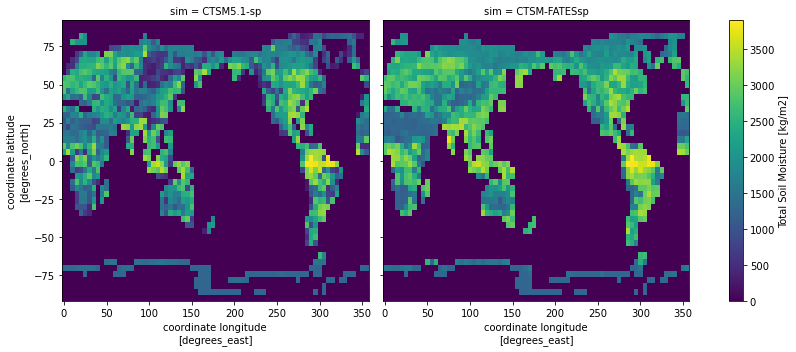

In [11]:
ds.totalSM.isel(time=6).plot(x='lon',y='lat',col="sim", col_wrap=2, figsize=(12,5));

In [28]:
## add a mask to get rid of data with no soil moisture
smMask = ds.totalSM.max('time')
ds = ds.where(smMask>0)

We can also plot every month from the year of data we read from the files. Here we do that for a single simulation, specified by `(sim=0)`

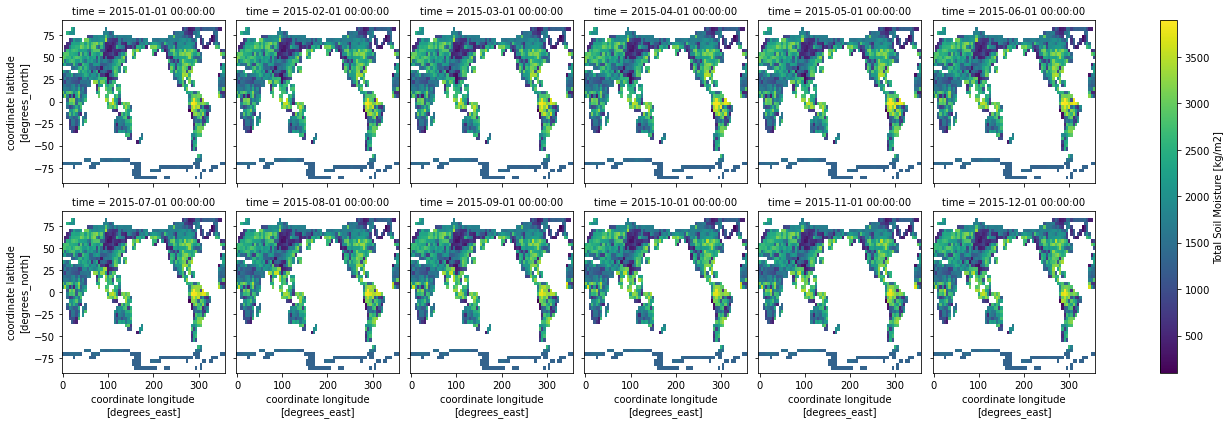

In [29]:
ds.totalSM.isel(sim=0).plot(x='lon',y='lat',col="time", col_wrap=6) ;

### 2.2 Calculating differences

In the previous section, it was difficult to see output differences between the simulations in side-by-side comparisons. We can calculate the differences between the simulations to more clearly see the differences and to understand how model structure, specifically the difference between CLM-FATESsp and CLM5.1sp, change the variable results. The below code:
- Subtracts CLM5.1sp from CLM-FATESsp 
- Defines the difference as a new variable, `dsDiff`

We'll first plot maps of the difference in total soil moisture for each month. 

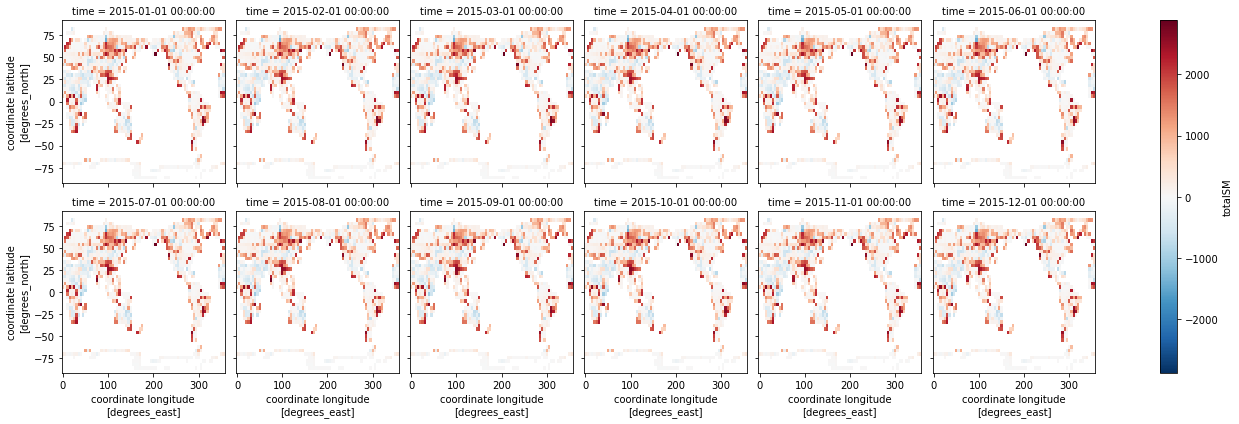

In [30]:
dsDiff = ds.sel(sim='CTSM-FATESsp') - ds.sel(sim='CTSM5.1-sp')
dsDiff.totalSM.plot(x='lon',y='lat',col="time", col_wrap=6, robust=False) ;
#ds

**Questions:** 
- How is total soil moisture different in CTSM-FATESsp and CTSM5.1-sp?
- Where are the differences the largest? 
- Are the differences consistent throughout the year?
- Since these simulations have the same climate and LAI, what's driving the differences in soil moisture in different regions?

**Comment**
- The difference in land model parameterization and parameter choices on the behavior of variables such as soil moisture can influence the coupling of the model in the ESM context, as well as have implications for societally-relevant concerns including regional water security.  While it's often difficult to diagnose fully the exact causes for changes in results, it's nonetheless important to provide explanations to simulation stakeholders and model developers to the extent possible. Fortunately, new hydrology-related metrics are under development in several new CTSM-related projects.  

<div class="alert alert-block alert-info">
<b>ISSUES:</b> CTSM and FATES model developers use GitHub issues to identify bugs, make model improvements, and track code developments.  You can watch these conversations, contribute to onging discussions, or create new issues when you find a problem with the model.
</div>

### 2.3 Calculating Time Series
As above, the plotting function we use here requires data to be 1D or 2D. Therefore, to plot a time series we either need to select a single point or average over an area.

#### 2.3.1 Time series at a single point
This example uses `.sel`, which functions similarly to the `.isel` function above, to select a single point in the Amazon. 

*What's the difference between `.sel` and `.isel`?*
- *`.sel` selects a value of a variable (e.g., latitude of -5)*
- *`.isel` selects an indexed point of a variable (e.g., the 6th point in the data vector)*

In the below examples, we'll also use subplots to see multiple variables in several panels

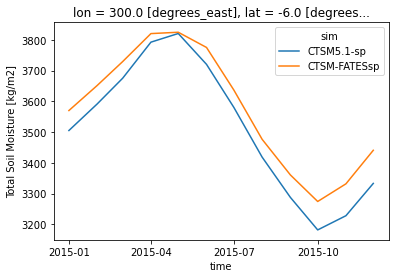

In [31]:
point = ds.sel(lon=300, lat=-5, method='nearest')
point.totalSM.plot(hue='sim',x='time') ;

Similar to the maps above, there are differences in soil moisture between the simulations at this location. We can add other related variables to the plot to provide more context for the differences at this location. 

#### 2.3.2 Global time series
There are many reasons why we may want to calculate globally integrated time series for particular variables.
This requires weighting the values from each grid cell by the total land area of individual grid cells. The example below does this for our dataset. 

#### First calculate the land weights:
- land area `la` that is the product of land fraction (fraction of land area in each grid cell) and the total area of the grid cell (which changes by latitude). Units are the same as area.
- land weights `lw`, the fractional weight that each grid makes to the global total, is calculated as the land area of each grid cell divided by the global sum of the land area.

The land weights are shown in the plot below. Note that these are larger near the equator, and smaller at the poles and along the coastline

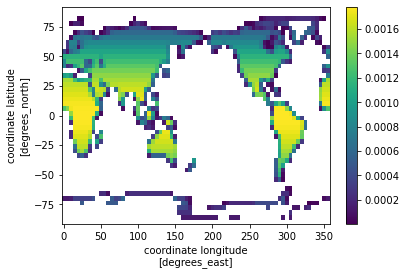

In [32]:
la = (ds.landfrac*ds.area).isel(time=0,sim=0).drop(['time','sim']) 
la = la * 1e6  #converts from land area from km2 to m2 
la.attrs['units'] = 'm^2'
lw = la/la.sum()
lw.plot() ;

#### Next, calculate and plot a global weighted sum
<div class="alert alert-block alert-info">

<b>NOTE:</b>  You will likely want to calculate global weighted sum for a variety of different variables. For variables that have area-based units (e.g. GPP, gC/<b>m^2</b>/s), you need to use the land area variable when calculating a global sum. <b> Remember to pay attention to the units and apply any necessary conversions!</b> Keep in mind that grid cell area is reported in km^2. 

</div>


#### Let's define some plotting variables that will be used in several examples below

In [33]:
plotVars = ['totalSM','totalET','H2OSNO','QRUNOFF']

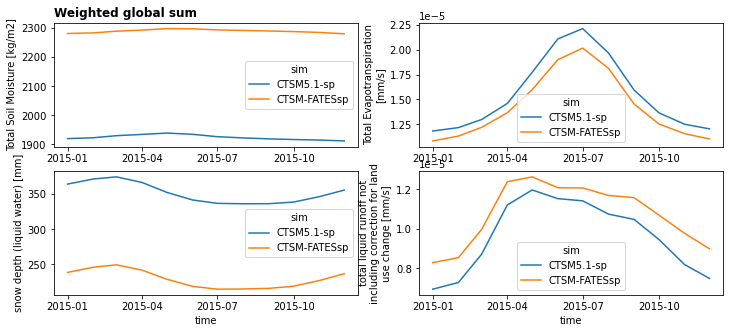

In [34]:
dsGlobalWgt = (ds * lw).sum(['lat','lon'])

plt.figure(figsize=(12,5))
for i in range(len(plotVars)):
    # First add metadata for plotting
    dsGlobalWgt[plotVars[i]].attrs['long_name'] = ds[plotVars[i]].attrs['long_name']
    dsGlobalWgt[plotVars[i]].attrs['units'] = ds[plotVars[i]].attrs['units']

    # then make plots
    plt.subplot(2,2,(i+1))
    dsGlobalWgt[plotVars[i]].plot(hue='sim')
    
    if i == 0:
        plt.title('Weighted global sum',loc='left', fontsize='large', fontweight='bold')
        
    if i<2:
        plt.xlabel(None)

---
### 2.4 Calculate an annual weighted mean and create customized plots
Annual averages require a different kind of weighting: the number of days per month.
This example creates python functions that allow you to easily calculate annual averages and create customized plots. 

<div class="alert alert-block alert-info">

<b>Python functions:</b> In python, creating a function allows us to use the same calculation numerous times instead of writing the same code repeatedly.
</div>


#### 2.4.1 Calculate monthly weights
The below code creates a function `weighted_annual_mean` to calculate monthly weights. Use this function any time you want to calculate weighted annual means.

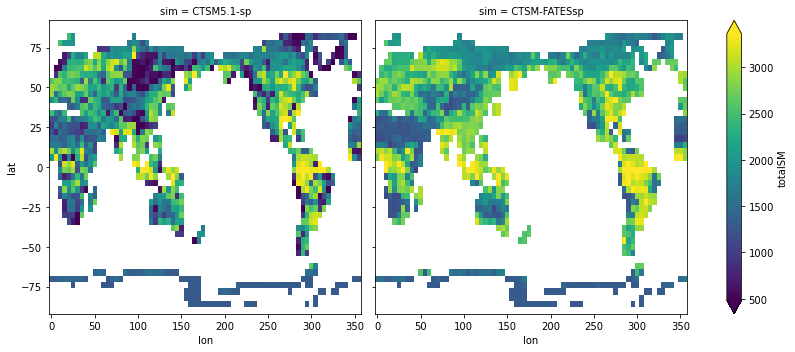

In [35]:
# create a function that will calculate an annual mean weighted by days per month
def weighted_annual_mean(array):
    mon_day  = xr.DataArray(np.array([31,28,31,30,31,30,31,31,30,31,30,31]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

# generate annual means
for i in range(len(plotVars)):
    temp = weighted_annual_mean(
        ds[plotVars[i]].chunk({"time": 12}))
    
    if i == 0:
        dsAnn = temp.to_dataset(name=plotVars[i])
    else:
        dsAnn[plotVars[i]] = temp

# Make a simple plot
dsAnn.totalSM.plot(x='lon',y='lat',col='sim', col_wrap=2, robust=True, figsize=(12,5)) ;

#### 2.4.2 Customized maps
Creating a function isn't necessary to plot maps, but this function, which uses python's `cartopy`, allows you to make several pretty maps in one figure.

Additional examples and information are available on the [cartopy website](https://scitools.org.uk/cartopy/docs/v0.15/index.html)

There are several code blocks below. The first block of code defines the function. The remainder use the function while creating the actual plots.  They mainly differ in the variables being specified and the control on their displayed ranges. 

In [36]:
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import copy

# Generate a function for making panel plots of maps
## many of these features are not required, but provide additional control over plotting
def map_function(da, cb=0, cmap='viridis', panel=None,  ax=None, 
                 title=None, vmax=None, vmin=None, units=None,nbins=200):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()

    # define the colormap, including the number of bins
    cmap = copy.copy(plt.get_cmap(cmap,nbins))
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)

    # set the bounds of your plot
    ax.set_extent([-180,180,-56,85], crs=ccrs.PlateCarree())

    # add title & panel labels
    ax.set_title(title,loc='left', fontsize='large', fontweight='bold')
    ax.annotate(panel, xy=(0.05, 0.90), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    

    # add plotting features
    ax.coastlines()
    ocean = ax.add_feature(
        cfeature.NaturalEarthFeature('physical','ocean','110m', facecolor='white'))
    
    # control colorbars on each plot & their location
    if cb == 1:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.03, orientation='horizontal')
        cbar.set_label(units,size=12,fontweight='bold')
    if cb == 2:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.05, orientation='vertical')    
        cbar.set_label(units,size=12)#,weight='bold')

#### Now make the plots!

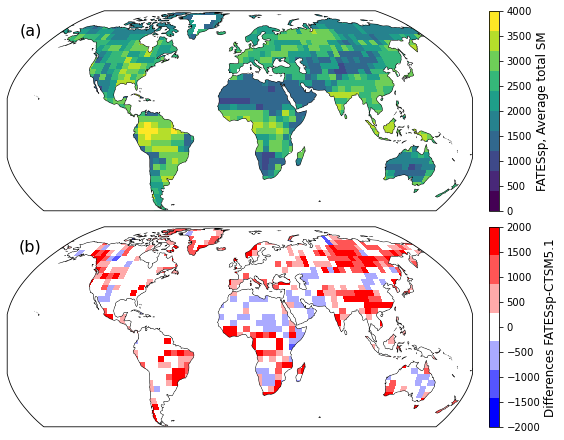

In [37]:
i = 0
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
for index, ax in np.ndenumerate(axes):
    if i == 0:
        plotData = dsAnn.totalSM.isel(sim=1,time=0).drop(['sim','time'])
        map_function(plotData, ax=ax,cb=2,
                     panel='(a)', nbins=10,
                     vmax=4000,vmin=0,
                     units='FATESsp, Average total SM')
    if i == 1:
        plotData = (dsAnn.totalSM.isel(sim=1,time=0)- \
                    dsAnn.totalSM.isel(sim=0,time=0))
        map_function(plotData, ax=ax,cb=2,panel='(b)',
                     units='Differences FATESsp-CTSM5.1',
                     cmap='bwr',nbins=7,
                     vmax=2000,vmin=-2000)    
                     
    i = i+1

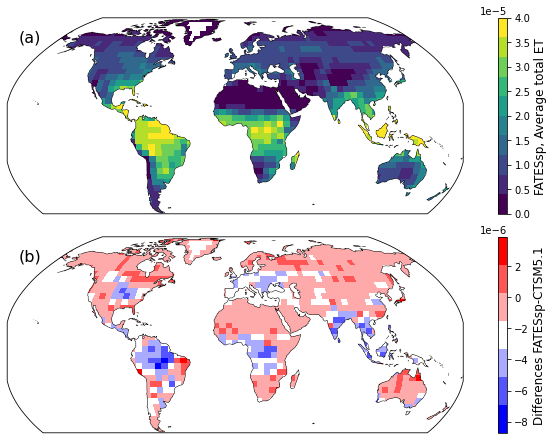

In [38]:
i = 0
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
for index, ax in np.ndenumerate(axes):
    if i == 0:
        plotData = dsAnn.totalET.isel(sim=1,time=0).drop(['sim','time'])
        map_function(plotData, ax=ax,cb=2,
                     panel='(a)', nbins=10,
                     vmax=4e-5,vmin=0,
                     units='FATESsp, Average total ET')
    if i == 1:
        plotData = (dsAnn.totalET.isel(sim=1,time=0)- \
                    dsAnn.totalET.isel(sim=0,time=0))
        map_function(plotData, ax=ax,cb=2,panel='(b)',
                     units='Differences FATESsp-CTSM5.1',
                     cmap='bwr',nbins=7,
                     #vmax=1,vmin=-1,
                     )    
                     
    i = i+1

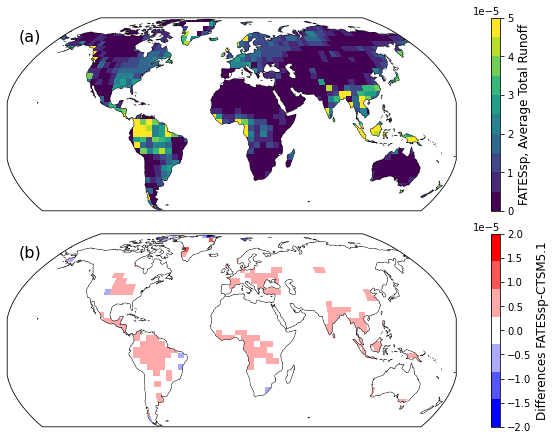

In [39]:
i = 0
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
for index, ax in np.ndenumerate(axes):
    if i == 0:
        plotData = dsAnn.QRUNOFF.isel(sim=1,time=0).drop(['sim','time'])
        map_function(plotData, ax=ax,cb=2,
                     panel='(a)', nbins=10,
                     vmax=5e-5,vmin=0,
                     units='FATESsp, Average Total Runoff')
    if i == 1:
        plotData = (dsAnn.QRUNOFF.isel(sim=1,time=0)- \
                    dsAnn.QRUNOFF.isel(sim=0,time=0))
        map_function(plotData, ax=ax,cb=2,panel='(b)',
                     units='Differences FATESsp-CTSM5.1',
                     cmap='bwr',nbins=7,
                     vmax=2e-5,vmin=-2e-5,
                     )    
    i = i+1

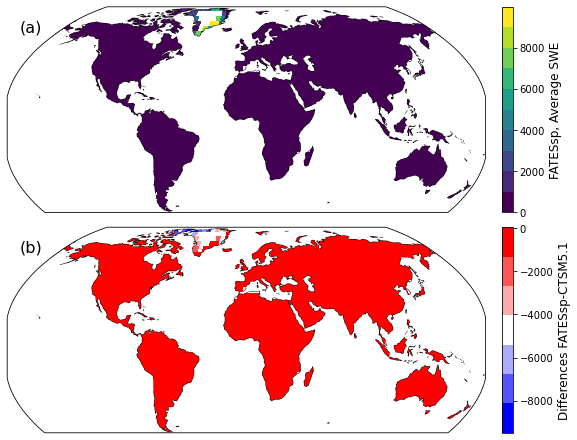

In [40]:
i = 0
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
for index, ax in np.ndenumerate(axes):
    if i == 0:
        plotData = dsAnn.H2OSNO.isel(sim=1,time=0).drop(['sim','time'])
        map_function(plotData, ax=ax,cb=2,
                     panel='(a)', nbins=10,
                     #vmax=8,vmin=0,
                     units='FATESsp, Average SWE')
    if i == 1:
        plotData = (dsAnn.H2OSNO.isel(sim=1,time=0)- \
                    dsAnn.H2OSNO.isel(sim=0,time=0))
        map_function(plotData, ax=ax,cb=2,panel='(b)',
                     units='Differences FATESsp-CTSM5.1',
                     cmap='bwr',nbins=7,
                     #vmax=1,vmin=-1,
                     )    
    i = i+1

In parts of the domain, a physically intuitive storyline emerges -- e.g., in the central Amazon, while soil moisture remains similar, higher ET leads to descreased runoff.  In other parts of the domain, the analysis is less clear. If course, this is a demonstration case rather than a real experiment, but it is good to see that results can have plausible behavior!